In [1]:
# noexport

!typech retention_utils.ipynb

retention_utils.py:448: error: Name 'get_ipython' is not defined
retention_utils.py:511: error: Name 'get_ipython' is not defined
retention_utils.py:515: error: Name 'get_ipython' is not defined
Found 3 errors in 1 file (checked 1 source file)


In [2]:
#%reload_ext rpy2.ipython

In [3]:
#import r_utils
#reload(r_utils)
from r_utils import r, r_assign

In [4]:
from train_utils import *

In [5]:
install_active_dates = get_collection_items('install_active_dates')

In [6]:
install_active_dates[0]

{'_id': '20180324_8cb60c331ebf24f18a62244d',
 'day': '20180324',
 'user': '23423fe59adc79493079b0f1',
 'install': '8cb60c331ebf24f18a62244d'}

In [7]:
# noexport

jsonmemo_module.set_lowmem(True)

In [8]:
def is_valid_date(date):
  if date is None:
    return False
  if type(date) != str:
    return False
  year = int(date[0:4])
  month = int(date[4:6])
  day = int(date[6:8])
  if year < 2020:
    return True
  if year == 2020:
    if month < 5:
      return True
    elif month > 5:
      return False
    elif month == 5:
      if day <= 22: # 5/27 gives 533. we want 528 days. so 5/22.
        return True
      else:
        return False
  return False

# print(is_valid_date(install_active_dates[0]['day']))
# print(is_valid_date('20200610'))
# print(is_valid_date('20200510'))
# print(is_valid_date('20210510'))
# print(is_valid_date('20200518'))
# print(is_valid_date('20200527'))
# print(is_valid_date('20200528'))


In [9]:
@msgpackmemo
def get_install_to_dates_active_list_olddata():
  output = {}
  for install,dates_active_set in get_install_to_dates_active_set_olddata().items():
    dates_active_list = sorted(list(dates_active_set))
    output[install] = dates_active_list
  return output

In [10]:
def get_install_to_dates_active_set_olddata():
  install_active_dates = get_collection_items('install_active_dates')
  install_active_dates = [x for x in install_active_dates if is_valid_date(x.get('day'))]
  output = {}
  #weird_items = []
  for item in install_active_dates:
    if 'day' not in item or 'install' not in item:
      #weird_items.append(item)
      continue
    day = item['day']
    install = item['install']
    if install not in output:
      output[install] = set()
    output[install].add(day)
  #print(len(weird_items))
  #print(weird_items[:100])
  return output

#print(user_active_dates[0])

In [11]:
@msgpackmemo
def get_user_to_dates_active_list_olddata():
  output = {}
  for user,dates_active_set in get_user_to_dates_active_set_olddata().items():
    dates_active_list = sorted(list(dates_active_set))
    output[user] = dates_active_list
  return output

In [12]:
def get_user_to_dates_active_set_olddata():
  user_active_dates = get_collection_items('user_active_dates')
  user_active_dates = [x for x in user_active_dates if is_valid_date(x.get('day'))]
  output = {}
  #weird_items = []
  for item in user_active_dates:
    if 'day' not in item or 'user' not in item:
      #weird_items.append(item)
      continue
    day = item['day']
    user = item['user']
    if user not in output:
      output[user] = set()
    output[user].add(day)
  #print(len(weird_items))
  #print(weird_items[:100])
  return output

#print(user_active_dates[0])

In [13]:
def get_date_to_users_active_set_olddata():
  output = {}
  for user,dates_active_list in get_user_to_dates_active_list_olddata().items():
    for date in dates_active_list:
      if date not in output:
        output[date] = set()
      output[date].add(user)
  return output

In [14]:
@msgpackmemo
def get_date_to_users_active_list_olddata():
  output = {}
  for date,users_active_set in get_date_to_users_active_set_olddata().items():
    output[date] = sorted(list(users_active_set))
  return output

In [15]:
def get_date_to_installs_active_set_olddata():
  output = {}
  for install,dates_active_list in get_install_to_dates_active_list_olddata().items():
    for date in dates_active_list:
      if date not in output:
        output[date] = set()
      output[date].add(install)
  return output

In [16]:
@msgpackmemo
def get_date_to_installs_active_list_olddata():
  output = {}
  for date,installs_active_set in get_date_to_installs_active_set_olddata().items():
    output[date] = sorted(list(installs_active_set))
  return output

In [17]:
from datetime import datetime
from dateutil import tz

def get_epoch_start_arrowdate():
  return arrow.get(datetime(2016, 1, 1)) #, tz.gettz('US/Pacific'))

def convert_date_to_arrowdate(date):
  year = int(date[0:4])
  month = int(date[4:6])
  day = int(date[6:8])
  return arrow.get(datetime(year, month, day)) #, tz.gettz('US/Pacific'))

def get_dump_date():
  return sorted(list(get_date_to_users_active_list_olddata().keys()))[-1]

def get_dump_arrowdate():
  dump_date = get_dump_date()
  return convert_date_to_arrowdate(dump_date)

def get_dump_epoch():
  dump_arrowdate = get_dump_arrowdate()
  return convert_arrowdate_to_epoch(dump_arrowdate)

def convert_arrowdate_to_epoch(arrowdate):
  return (arrowdate - get_epoch_start_arrowdate()).days

def convert_date_to_epoch(date):
  arrowdate = convert_date_to_arrowdate(date)
  return convert_arrowdate_to_epoch(arrowdate)

In [18]:
@msgpackmemo
def get_user_to_retention_info_olddata():
  output = {}
  dump_epoch = get_dump_epoch()
  for user,dates_active in get_user_to_dates_active_list_olddata().items():
    epochs_active = sorted([convert_date_to_epoch(x) for x in dates_active])
    first_active = epochs_active[0]
    last_active = epochs_active[-1]
    days_alive = last_active - first_active
    is_alive = (dump_epoch - last_active) <= 4
    attritioned = not is_alive
    output[user] = {'lifetime': days_alive, 'attritioned': attritioned}
  return output

In [19]:
@msgpackmemo
def get_install_to_retention_info_olddata():
  output = {}
  dump_epoch = get_dump_epoch()
  for install,dates_active in get_install_to_dates_active_list_olddata().items():
    epochs_active = sorted([convert_date_to_epoch(x) for x in dates_active])
    first_active = epochs_active[0]
    last_active = epochs_active[-1]
    days_alive = last_active - first_active
    is_alive = (dump_epoch - last_active) <= 4
    attritioned = not is_alive
    output[install] = {'lifetime': days_alive, 'attritioned': attritioned}
  return output

In [20]:
def to_dataframe(list_of_dict):
  columns = list(list_of_dict[0].keys())
  d = {}
  for column in columns:
    d[column] = []
    for item in list_of_dict:
      d[column].append(item[column])
  return pd.DataFrame(d)


In [21]:
def get_all_user_retentions_dataframe():
  user_retentions = []
  for user,retention_info in get_user_to_retention_info_olddata().items():
    user_retentions.append(retention_info)
  return to_dataframe(user_retentions)

In [22]:
def get_retention_info_for_groups_to_installs(group_to_installs, category_name):
  output = []
  install_to_retention_info = get_install_to_retention_info_olddata()
  for group,install_list in group_to_installs.items():
    for install in install_list:
      if get_is_install_unofficial(install):
        continue
      if install not in install_to_retention_info:
        continue
      retention_info = install_to_retention_info[install]
      output.append({
        'lifetime': retention_info['lifetime'],
        'attritioned': retention_info['attritioned'],
        'install': install,
        category_name: group,
      }) 
  return to_dataframe(output)

In [23]:
def get_retention_info_for_groups_to_users(group_to_users, category_name):
  output = []
  user_to_retention_info = get_user_to_retention_info_olddata()
  for group,user_list in group_to_users.items():
    for user in user_list:
      if get_is_user_unofficial(user):
        continue
      retention_info = user_to_retention_info[user]
      output.append({
        'lifetime': retention_info['lifetime'],
        'attritioned': retention_info['attritioned'],
        category_name: group,
      })
  return to_dataframe(output)

In [24]:
def get_retention_info_by_frequency_of_choose_difficulty_by_install():
  condition_to_installs = get_conditions_to_install_list_in_abtest('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])
  return get_retention_info_for_groups_to_installs(condition_to_installs, 'frequency_of_choose_difficulty')

In [25]:
def get_retention_info_by_frequency_of_choose_difficulty_by_user():
  condition_to_users = get_conditions_to_user_list_in_abtest('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])
  return get_retention_info_for_groups_to_users(condition_to_users, 'frequency_of_choose_difficulty')

In [26]:
# def get_retention_info_by_frequency_of_choose_difficulty_by_install():
#   output = []
#   install_list = get_installs_with_choose_difficulty()
#   install_to_retention_info = get_install_to_retention_info()
#   for install in install_list:
#     if get_is_install_unofficial(install):
#       continue
#     abtest_settings = get_abtest_settings_for_install(install)
#     frequency_of_choose_difficulty = abtest_settings.get('frequency_of_choose_difficulty')
#     if frequency_of_choose_difficulty == None:
#       continue
#     conditions = get_abtest_experiment_conditions_for_install(install).get('frequency_of_choose_difficulty')
#     if conditions != ['0.0', '0.25', '0.5', '1.0']:
#       continue
#     retention_info = install_to_retention_info[install]
#     output.append({
#       'lifetime': retention_info['lifetime'],
#       'attritioned': retention_info['attritioned'],
#       'frequency_of_choose_difficulty': frequency_of_choose_difficulty,
#     })
#   return to_dataframe(output)

In [27]:
# def get_retention_info_by_frequency_of_choose_difficulty():
#   output = []
#   user_list = get_users_with_choose_difficulty()
#   user_to_retention_info = get_user_to_retention_info()
#   for user in user_list:
#     if get_is_user_unofficial(user):
#       continue
#     abtest_settings = get_abtest_settings(user)
#     frequency_of_choose_difficulty = abtest_settings.get('frequency_of_choose_difficulty')
#     if frequency_of_choose_difficulty == None:
#       continue
#     conditions = get_abtest_experiment_conditions(user).get('frequency_of_choose_difficulty')
#     if conditions != ['0.0', '0.25', '0.5', '1.0']:
#       continue
#     retention_info = user_to_retention_info[user]
#     output.append({
#       'lifetime': retention_info['lifetime'],
#       'attritioned': retention_info['attritioned'],
#       'frequency_of_choose_difficulty': frequency_of_choose_difficulty,
#     })
#   return to_dataframe(output)

In [28]:
import r_utils
reload(r_utils)
from r_utils import r, r_assign

def plot_attrition(pandas_df, varname):
  r_assign('plot_attrition_df', pandas_df)
  r(f"""
  plot_attrition_df$lifetime <- as.numeric(plot_attrition_df$lifetime)
  plot_attrition_df$attritioned <- as.logical(plot_attrition_df$attritioned)
  plot_attrition_df${varname} <- as.factor(plot_attrition_df${varname})
  library("survival")
  library("survminer")
  fit <- survfit(Surv(lifetime, attritioned) ~ {varname}, data=plot_attrition_df)
  summary(fit)
  ggsurv <- ggsurvplot(fit,
    pval = TRUE, conf.int = TRUE,
    risk.table = "percentage", # Add risk table
    xlab = "Time in days",
    #risk.table = TRUE, # Add risk table
    risk.table.col = "strata", # Change risk table color by groups
    risk.table.y.text = FALSE,
    linetype = "strata", # Change line type by groups
    surv.median.line = "hv", # Specify median survival
    ggtheme = theme_bw(), # Change ggplot2 theme
    tables.theme = clean_theme(),
    #font.x = 40, #c(80, "bold"),
    #font.y = 40, #c(80, "bold"),
    #risk.table.fontsize = 40,
    #pval.size = 60,
  )
  #ggsurv$plot <- ggsurv$plot + theme(legend.text = element_text(size = 60, color = "black"))
  #ggsurv$plot <- ggsurv$plot + theme(legend.text = element_text(size = 80, color = "black", face = "bold"))
  ggsurv
  """)
#   r(f"""
#   plot_attrition_df$lifetime <- as.numeric(plot_attrition_df$lifetime)
#   plot_attrition_df$attritioned <- as.logical(plot_attrition_df$attritioned)
#   plot_attrition_df${varname} <- as.factor(plot_attrition_df${varname})
#   library("survival")
#   library("survminer")
#   fit <- survfit(Surv(lifetime, attritioned) ~ {varname}, data=plot_attrition_df)
#   summary(fit)
#   plot_attrition_func <- function() {{
    
#   }}
#   """)
#   %R -w 1000 print(plot_attrition_func())


def plot_attrition_save(pandas_df, varname, savename):
  r_assign('plot_attrition_df', pandas_df)
  r(f"""
  plot_attrition_df$lifetime <- as.numeric(plot_attrition_df$lifetime)
  plot_attrition_df$attritioned <- as.logical(plot_attrition_df$attritioned)
  plot_attrition_df${varname} <- as.factor(plot_attrition_df${varname})
  library("survival")
  library("survminer")
  fit <- survfit(Surv(lifetime, attritioned) ~ {varname}, data=plot_attrition_df)
  summary(fit)
  pp <- ggsurvplot(fit,
    pval = TRUE, conf.int = TRUE,
    risk.table = "percentage", # Add risk table
    xlab = "Time in days",
    #risk.table = TRUE, # Add risk table
    risk.table.col = "strata", # Change risk table color by groups
    risk.table.y.text = FALSE,
    linetype = "strata", # Change line type by groups
    surv.median.line = "hv", # Specify median survival
    ggtheme = theme_bw(), # Change ggplot2 theme
    tables.theme = clean_theme(),

  )
  ggsave("{savename}.png", plot=print(pp), dpi = 300)
  """)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [29]:
def plot_attrition_for_abtest_groups_by_install(abtest_name, groups):
  condition_to_installs = get_conditions_to_install_list_in_abtest(abtest_name, groups)
  retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, abtest_name)
  plot_attrition(retention_info, abtest_name)

def plot_attrition_for_abtest_groups_by_user(abtest_name, groups):
  condition_to_users = get_conditions_to_user_list_in_abtest(abtest_name, groups)
  retention_info = get_retention_info_for_groups_to_users(condition_to_users, abtest_name)
  plot_attrition(retention_info, abtest_name)

def plot_attrition_for_abtest_groups_by_install_unstrict(abtest_name, groups):
  condition_to_installs = get_conditions_to_install_list_in_abtest_unstrict(abtest_name)
  for k in list(condition_to_installs.keys()):
    if k not in groups:
      del condition_to_installs[k]
  retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, abtest_name)
  plot_attrition(retention_info, abtest_name)

In [30]:
def get_conditions_to_install_list_in_abtest_unstrict(abtest_name):
  output = {}
  #for install in get_installs_with_choose_difficulty():
  for install in get_installs_with_experiment_vars():
    abtest_settings = get_abtest_settings_for_install(install)
    if abtest_name not in abtest_settings:
      continue
    condition = abtest_settings[abtest_name]
    #all_abtest_conditions = get_abtest_experiment_conditions_for_install(install)
    #if abtest_name not in all_abtest_conditions:
    #  continue
    #all_conditions = all_abtest_conditions[abtest_name]
    #if all_conditions != abtest_conditions:
    #  continue
    if condition not in output:
      output[condition] = []
    output[condition].append(install)
  return output


In [31]:
# def make_attrition_plot_by_install_for_frequency_of_choose_difficulty():
#   plot_attrition(get_retention_info_by_frequency_of_choose_difficulty_by_install(), 'frequency_of_choose_difficulty')

# def make_attrition_plot_by_user_for_frequency_of_choose_difficulty():
#   plot_attrition(get_retention_info_by_frequency_of_choose_difficulty_by_user(), 'frequency_of_choose_difficulty')

def make_attrition_plot_by_install_for_frequency_of_choose_difficulty():
  plot_attrition_for_abtest_groups_by_install('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])

def make_attrition_plot_by_user_for_frequency_of_choose_difficulty():
  plot_attrition_for_abtest_groups_by_user('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])

def make_attrition_plot_by_install_for_randomized_difficulty_assignments():
  plot_attrition_for_abtest_groups_by_install_unstrict('difficulty_selection_screen', ['survey_nochoice_nothing', 'survey_nochoice_easy', 'survey_nochoice_medium', 'survey_nochoice_hard'])


In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

R[write to console]: 载入需要的程辑包：ggplot2

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

R[write to console]: 载入需要的程辑包：ggpubr

R[write to console]: 载入需要的程辑包：magrittr



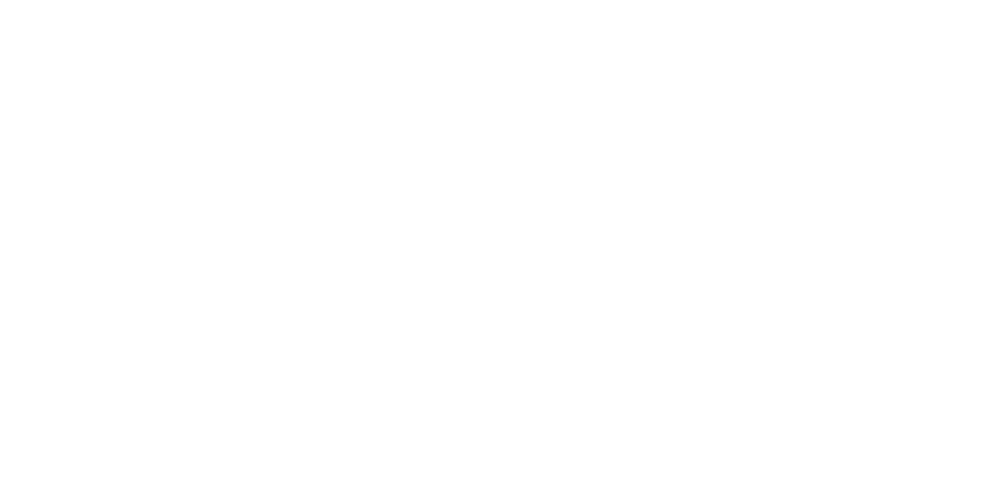

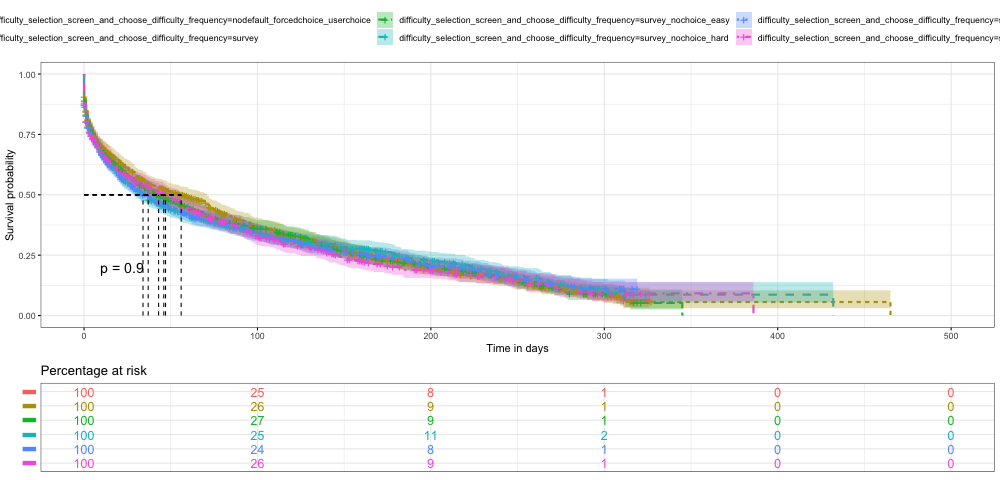

In [33]:
# noexport

#get_conditions_to_install_list_in_abtest_unstrict('difficulty_selection_screen_and_choose_difficulty_frequency')

condition_to_installs = get_conditions_to_install_list_in_abtest('difficulty_selection_screen_and_choose_difficulty_frequency', ['survey', 'nodefault_forcedchoice_userchoice', 'survey_nochoice_nothing', 'survey_nochoice_easy', 'survey_nochoice_medium', 'survey_nochoice_hard'])
#print(condition_to_installs)
condition_to_installs['survey_nochoice_easy'].remove('3d8f23613f3849ed266ace58')
condition_to_installs['survey_nochoice_nothing'].remove('4d061e26d5746a4c1202a2ee')
condition_to_installs['survey_nochoice_easy'].remove('4923f5d68ea2b45c0e582fa9')
condition_to_installs['nodefault_forcedchoice_userchoice'].remove('0a02fa66d5236d68f5ad4f64')

retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, 'difficulty_selection_screen_and_choose_difficulty_frequency')
#print(retention_info[retention_info['lifetime'] > 59])
#print(retention_info[['lifetime']])
#plot_attrition_for_abtest_groups_by_install('difficulty_selection_screen_and_choose_difficulty_frequency', ['survey', 'nodefault_forcedchoice_userchoice', 'survey_nochoice_nothing', 'survey_nochoice_easy', 'survey_nochoice_medium', 'survey_nochoice_hard'])

# ['survey_nochoice_nothing', 'nodefault_forcedchoice_userchoice', 'survey_nochoice_medium', 'survey', 'survey_nochoice_easy', 'survey_nochoice_hard'])

plot_attrition(retention_info, 'difficulty_selection_screen_and_choose_difficulty_frequency')

In [34]:
# noexport

retention_info = retention_info.rename(columns={"difficulty_selection_screen_and_choose_difficulty_frequency": "Condition"})

In [35]:
# noexport

set(list(retention_info['Condition'])) #= map(lambda x: {'survey': 'Survey', }[x])

{'nodefault_forcedchoice_userchoice',
 'survey',
 'survey_nochoice_easy',
 'survey_nochoice_hard',
 'survey_nochoice_medium',
 'survey_nochoice_nothing'}

In [36]:
# noexport

retention_info['Condition'] = retention_info['Condition'].replace(
  'nodefault_forcedchoice_userchoice', 'Initial User Choice'
).replace(
  'survey', 'Continuous User Choice'
).replace(
  'survey_nochoice_easy', 'Easy'
).replace(
  'survey_nochoice_medium', 'Medium'
).replace(
  'survey_nochoice_hard', 'Hard'
).replace(
  'survey_nochoice_nothing', 'Nothing'
)


In [37]:
# noexport

print(len(list(retention_info['lifetime'])))
print(np.max(list(retention_info['lifetime'])))
print(np.mean(list(retention_info['lifetime'])))
print(np.median(list(retention_info['lifetime'])))
print(np.std(list(retention_info['lifetime'])))
print(np.sum(list(retention_info['lifetime'])))

#retention_info

5055
465
65.19347181008902
29.0
79.63087540283794
329553


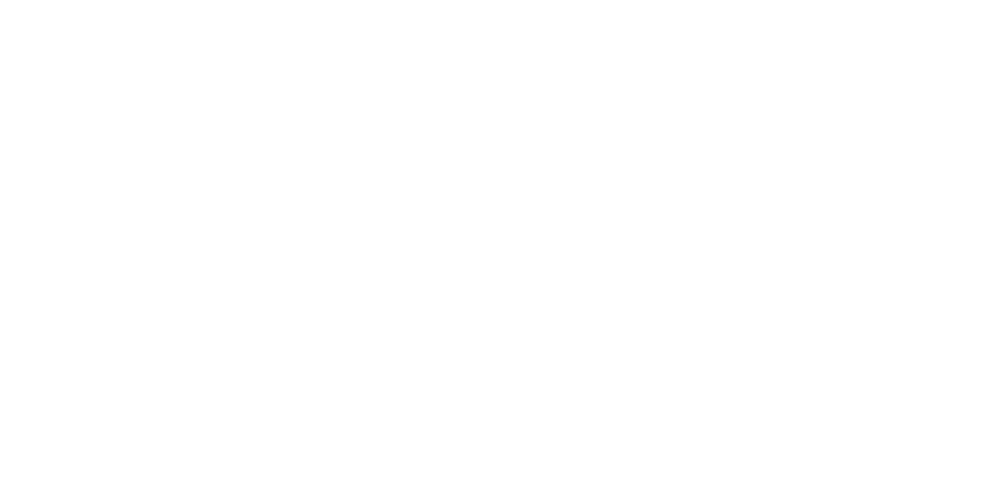

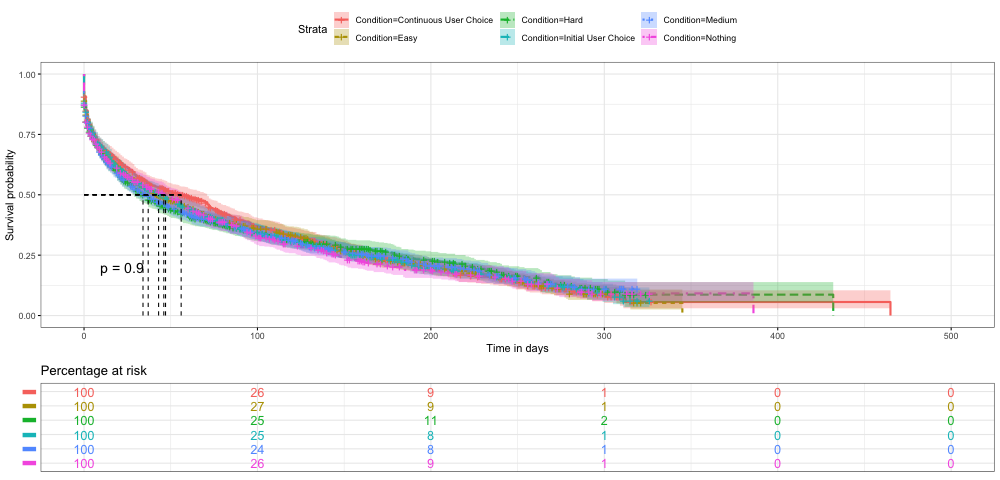

R[write to console]: Saving 13.9 x 6.67 in image



NULL


In [38]:
# noexport

plot_attrition(retention_info, 'Condition')
plot_attrition_save(retention_info, 'Condition', 'nochoice_retention')

In [40]:
# noexport

r_assign('plot_attrition_df', retention_info)


In [41]:
# noexport

#%%R -w 1000
r(f"""
  plot_attrition_df$lifetime <- as.numeric(plot_attrition_df$lifetime)
  plot_attrition_df$attritioned <- as.logical(plot_attrition_df$attritioned)
  plot_attrition_df$Condition <- as.factor(plot_attrition_df$Condition)
  plot_attrition_df$Condition <- factor(plot_attrition_df$Condition, levels = c('Nothing', 'Easy', 'Medium', 'Hard', 'Initial User Choice', 'Continuous User Choice'))
  library("survival")
  library("survminer")
  fit <- survfit(Surv(lifetime, attritioned) ~ Condition, data=plot_attrition_df)
  summary(fit)
  pp <- ggsurvplot(fit,
    pval = TRUE, conf.int = TRUE,
    risk.table = "percentage", # Add risk table
    xlab = "Time in days",
    #risk.table = TRUE, # Add risk table
    risk.table.col = "strata", # Change risk table color by groups
    risk.table.y.text = FALSE,
    linetype = "strata", # Change line type by groups
    surv.median.line = "hv", # Specify median survival
    ggtheme = theme_bw(), # Change ggplot2 theme
    tables.theme = clean_theme(),
    #font.x = 40, #c(80, "bold"),
    #font.y = 40, #c(80, "bold"),
    #risk.table.fontsize = 40,
    #pval.size = 60,
  )
  ggsave("nochoice_retention.png", plot=print(pp), dpi = 300)

""")

R[write to console]: Saving 13.9 x 6.67 in image



NULL


In [41]:
# noexport

r(f"""

#ggsurv$plot <- ggsurv$plot + theme(legend.text = element_text(size = 60, color = "black"))
  #ggsurv$plot <- ggsurv$plot + theme(legend.text = element_text(size = 80, color = "black", face = "bold"))
  #ggsurv
  """)

NULL


In [42]:
# noexport

#plot_attrition(retention_info[(retention_info['difficulty_selection_screen_and_choose_difficulty_frequency'] == 'survey') | (retention_info['difficulty_selection_screen_and_choose_difficulty_frequency'] == 'nodefault_forcedchoice_userchoice')], 'difficulty_selection_screen_and_choose_difficulty_frequency')

In [43]:
# noexport

#plot_attrition(retention_info[(retention_info['difficulty_selection_screen_and_choose_difficulty_frequency'] == 'survey') | (retention_info['difficulty_selection_screen_and_choose_difficulty_frequency'] == 'survey_nochoice_hard')], 'difficulty_selection_screen_and_choose_difficulty_frequency')

In [44]:
# noexport

#plot_attrition(retention_info[(retention_info['difficulty_selection_screen_and_choose_difficulty_frequency'] == 'survey') | (retention_info['difficulty_selection_screen_and_choose_difficulty_frequency'] == 'survey_nochoice_nothing')], 'difficulty_selection_screen_and_choose_difficulty_frequency')

In [45]:
# def get_all_install_info_for_install_id(install_id):
#   install_info_list = get_collection_items('installs')
#   output = []
#   for install_info in install_info_list:
#     cur_install_id = install_info.get('install_id', None)
#     if cur_install_id == install_id:
#       output.append(install_info)
#   return output

In [46]:
# def get_all_install_info_for_user(user):
#   install_info_list = get_collection_items('installs')
#   output = []
#   for install_info in install_info_list:
#     cur_user_id = install_info.get('user_id', None)
#     if cur_user_id == user:
#       output.append(install_info)
#   return output

In [47]:
# noexport

#print(get_all_install_info_for_user('75cd18ca11249ef7de22c241'))

In [48]:
# noexport

#print(get_all_install_info_for_install_id('3d8f23613f3849ed266ace58'))

In [49]:
# noexport

#collection_items = get_collection_for_user('75cd18ca11249ef7de22c241', 'synced:experiment_vars')

In [50]:
# noexport

#for x in collection_items:
#  print(x)

In [51]:
# noexport

#collection_items = get_collection_for_install('3d8f23613f3849ed266ace58', 'synced:experiment_vars')

In [52]:
# noexport

#for x in collection_items:
#  print(x)

In [53]:
# noexport

#print(get_abtest_settings_for_install('3d8f23613f3849ed266ace58'))

In [54]:
# noexport

#print(get_install_to_dates_active_list()['3d8f23613f3849ed266ace58'])

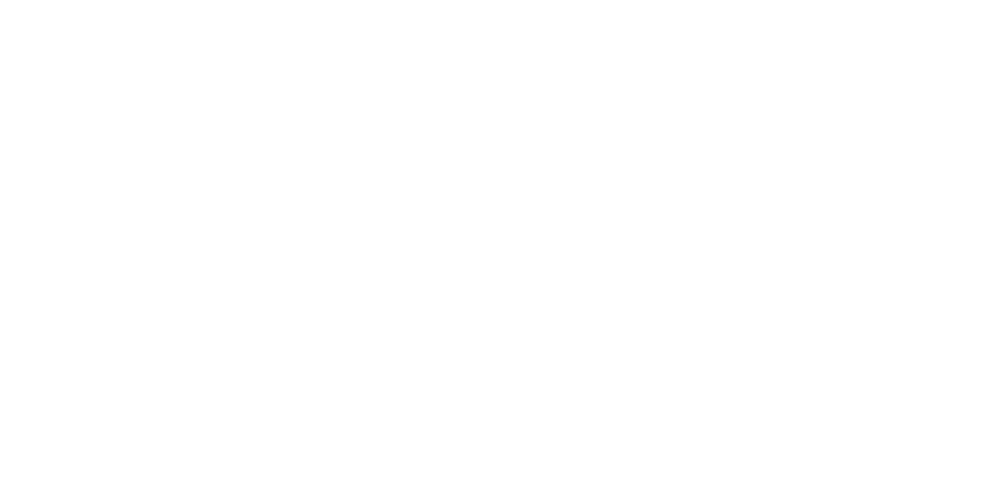

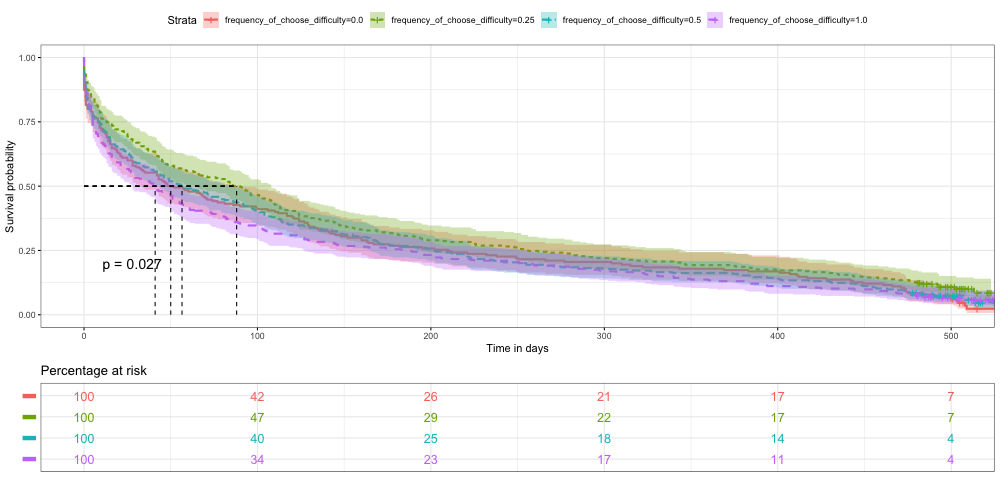

In [55]:
# noexport

make_attrition_plot_by_install_for_frequency_of_choose_difficulty()

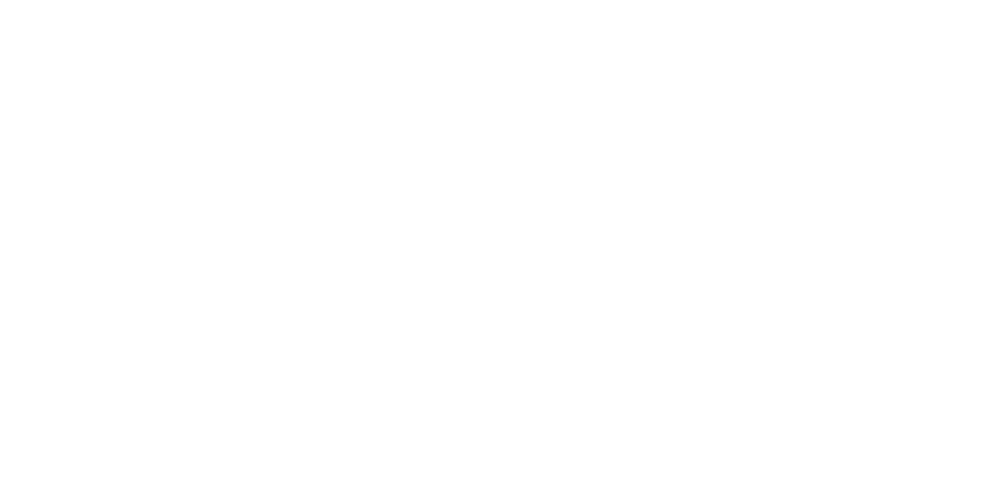

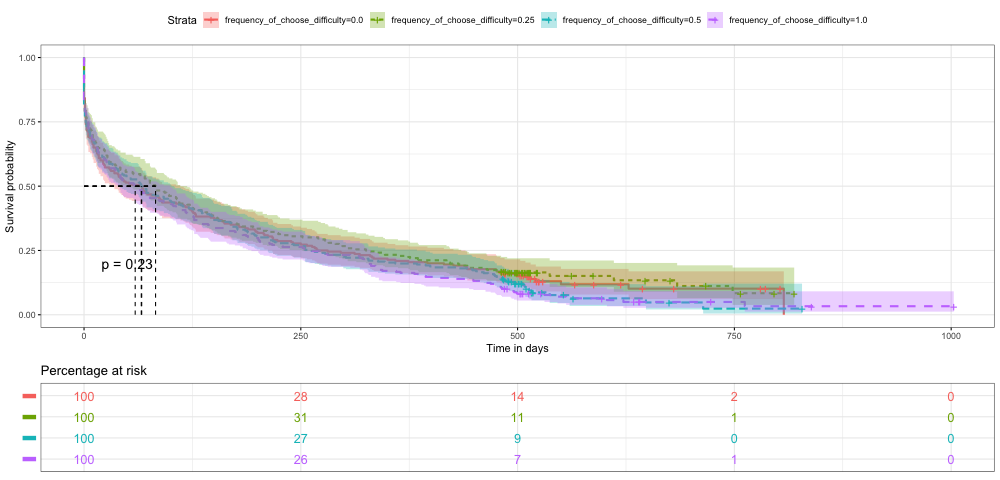

In [56]:
# noexport

make_attrition_plot_by_user_for_frequency_of_choose_difficulty()

In [57]:
# noexport

retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, 'frequency_of_choose_difficulty')

#print(retention_info[retention_info['lifetime'] > 0])


In [139]:
# noexport

#get_conditions_to_install_list_in_abtest_unstrict('difficulty_selection_screen_and_choose_difficulty_frequency')

#plot_attrition_for_abtest_groups_by_install('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])

condition_to_installs = get_conditions_to_install_list_in_abtest('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])
retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, 'frequency_of_choose_difficulty')
#plot_attrition(retention_info, 'frequency_of_choose_difficulty')


#condition_to_installs = plot_attrition_for_abtest_groups_by_install('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])
#print(condition_to_installs)
#condition_to_installs['survey_nochoice_easy'].remove('3d8f23613f3849ed266ace58')
#condition_to_installs['survey_nochoice_nothing'].remove('4d061e26d5746a4c1202a2ee')
#condition_to_installs['survey_nochoice_easy'].remove('4923f5d68ea2b45c0e582fa9')
#condition_to_installs['nodefault_forcedchoice_userchoice'].remove('0a02fa66d5236d68f5ad4f64')

#retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, 'frequency_of_choose_difficulty')
#print(retention_info[retention_info['lifetime'] > 600])
#print(retention_info[['lifetime']])
#plot_attrition_for_abtest_groups_by_install('difficulty_selection_screen_and_choose_difficulty_frequency', ['survey', 'nodefault_forcedchoice_userchoice', 'survey_nochoice_nothing', 'survey_nochoice_easy', 'survey_nochoice_medium', 'survey_nochoice_hard'])

# ['survey_nochoice_nothing', 'nodefault_forcedchoice_userchoice', 'survey_nochoice_medium', 'survey', 'survey_nochoice_easy', 'survey_nochoice_hard'])

#plot_attrition(retention_info, 'frequency_of_choose_difficulty')

In [140]:
# noexport

retention_info = retention_info.rename(columns={"frequency_of_choose_difficulty": "Frequency"})

In [141]:
# noexport

set(list(retention_info['Frequency'])) #= map(lambda x: {'survey': 'Survey', }[x])

{'0.0', '0.25', '0.5', '1.0'}

In [142]:
# noexport

retention_info['Frequency'] = retention_info['Frequency'].replace(
  '0.0', '0% of visits'
).replace(
  '0.25', '25% of visits'
).replace(
  '0.5', '50% of visits'
).replace(
  '1.0', '100% of visits'
)

In [143]:
max(retention_info['lifetime'].values)

528

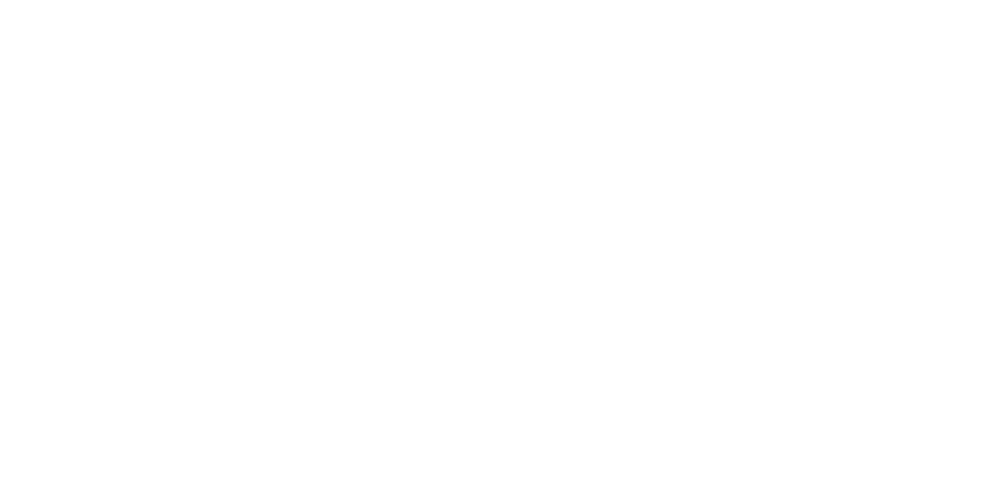

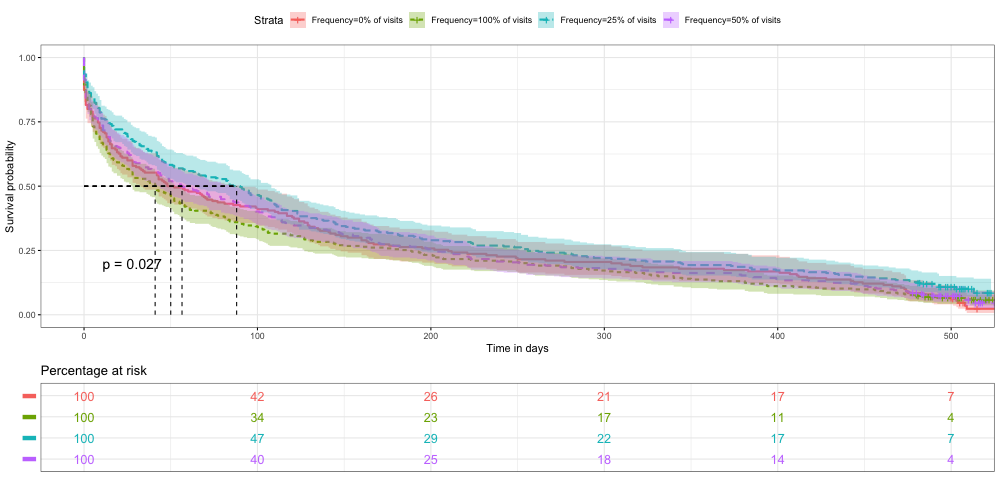

R[write to console]: Saving 13.9 x 6.67 in image



NULL


In [144]:
# noexport

plot_attrition(retention_info, 'Frequency')
plot_attrition_save(retention_info, 'Frequency', 'retention_costs')


In [145]:
# noexport

r_assign('plot_attrition_df', retention_info)


In [65]:
#plot_attrition_df

In [146]:
%%R -w 1000
plot_attrition_df$lifetime <- as.numeric(plot_attrition_df$lifetime)
plot_attrition_df$attritioned <- as.logical(plot_attrition_df$attritioned)
plot_attrition_df$Frequency <- as.factor(plot_attrition_df$Frequency)
plot_attrition_df$Frequency <- factor(plot_attrition_df$Frequency, levels = c('100% of visits', '50% of visits', '25% of visits', '0% of visits'))
library("survival")
library("survminer")
#fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
#fit <- survfit(res.cox, data=plot_attrition_df)
fit <- survfit(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
#fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
summary(fit)
ggsurv <- ggsurvplot(fit,
  pval = TRUE,
  pval.method = TRUE,
  conf.int = TRUE,
  censor = FALSE,
  risk.table = "percentage", # Add risk table
  xlab = "Time in days",
  #risk.table = TRUE, # Add risk table
  risk.table.col = "strata", # Change risk table color by groups
  risk.table.y.text = FALSE,
  linetype = "strata", # Change line type by groups
  surv.median.line = "hv", # Specify median survival
  ggtheme = theme_bw(), # Change ggplot2 theme
  tables.theme = clean_theme(),
  #font.x = 40, #c(80, "bold"),
  #font.y = 40, #c(80, "bold"),
  #risk.table.fontsize = 40,
  #pval.size = 60,
)
#ggsurv$plot <- ggsurv$plot + theme(legend.text = element_text(size = 60, color = "black"))
#ggsurv$plot <- ggsurv$plot + theme(legend.text = element_text(size = 80, color = "black", face = "bold"))
#ggsurv
ggsave("retention_costs.png", plot=print(ggsurv), dpi = 300)


R[write to console]: Saving 13.9 x 6.67 in image



In [148]:
%%R

fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
summary(fit)

Call:
coxph(formula = Surv(lifetime, attritioned) ~ Frequency, data = plot_attrition_df)

  n= 1108, number of events= 1029 

                           coef exp(coef) se(coef)      z Pr(>|z|)   
Frequency50% of visits -0.08903   0.91482  0.08258 -1.078  0.28101   
Frequency25% of visits -0.25303   0.77645  0.08523 -2.969  0.00299 **
Frequency0% of visits  -0.06746   0.93477  0.09438 -0.715  0.47479   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                       exp(coef) exp(-coef) lower .95 upper .95
Frequency50% of visits    0.9148      1.093    0.7781    1.0756
Frequency25% of visits    0.7764      1.288    0.6570    0.9176
Frequency0% of visits     0.9348      1.070    0.7769    1.1247

Concordance= 0.533  (se = 0.01 )
Likelihood ratio test= 9.43  on 3 df,   p=0.02
Wald test            = 9.24  on 3 df,   p=0.03
Score (logrank) test = 9.27  on 3 df,   p=0.03



In [147]:
%%R -w 1000

fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
summary(fit)
library('tab')
library('knitr')
show(kable(tabcoxph(fit), format='latex'))
#library(reporttools)
#displayCoxPH(fit)


\begin{tabular}{l|l|l|l}
\hline
Variable & Beta (SE) & HR (95\% CI) & P\\
\hline
Frequency &  &  & \\
\hline
\textbackslash{} \textbackslash{} \textbackslash{} 100\% of visits (ref) & - & - & -\\
\hline
\textbackslash{} \textbackslash{} \textbackslash{} 50\% of visits & -0.09 (0.08) & 0.91 (0.78, 1.08) & 0.28\\
\hline
\textbackslash{} \textbackslash{} \textbackslash{} 25\% of visits & -0.25 (0.09) & 0.78 (0.66, 0.92) & 0.003\\
\hline
\textbackslash{} \textbackslash{} \textbackslash{} 0\% of visits & -0.07 (0.09) & 0.93 (0.78, 1.12) & 0.47\\
\hline
\end{tabular}


In [69]:
%%R -w 1000

fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
library(texreg)
show(texreg(fit))
#library(stargazer)
#stargazer(fit)

R[write to console]: Version:  1.37.5
Date:     2020-06-17
Author:   Philip Leifeld (University of Essex)

Consider submitting praise using the praise or praise_interactive functions.
Please cite the JSS article in your publications -- see citation("texreg").

R[write to console]: 
载入程辑包：‘texreg’


R[write to console]: The following object is masked from ‘package:magrittr’:

    extract





\begin{table}
\begin{center}
\begin{tabular}{l c}
\hline
 & Model 1 \\
\hline
Frequency25\% of visits  & $-0.19$    \\
                         & $(0.10)$   \\
Frequency50\% of visits  & $-0.02$    \\
                         & $(0.09)$   \\
Frequency100\% of visits & $0.07$     \\
                         & $(0.09)$   \\
\hline
AIC                      & $12761.90$ \\
R$^2$                    & $0.01$     \\
Max. R$^2$               & $1.00$     \\
Num. events              & $1029$     \\
Num. obs.                & $1108$     \\
Missings                 & $0$        \\
PH test                  & $0.44$     \\
\hline
\multicolumn{2}{l}{\scriptsize{$^{***}p<0.001$; $^{**}p<0.01$; $^{*}p<0.05$}}
\end{tabular}
\caption{Statistical models}
\label{table:coefficients}
\end{center}
\end{table}
 FALSE

In [70]:
%%R -w 1000
fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
#summary(fit)

beta <- coef(fit)
se   <- sqrt(diag(fit$var))
p    <- 1 - pchisq((beta/se)^2, 1)
CI   <- round(confint(fit), 3)

res <- cbind(beta, se = exp(beta), CI, p)
#res <- res[c("age", "log(protime)"),]

library(xtable)
show(xtable(res))
#show(xtable(round(summary(fit)$conf.int[c(1,3),],3)))

% latex table generated in R 3.6.2 by xtable 1.8-4 package
% Wed Sep 16 19:08:19 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrr}
  \hline
 & beta & se & 2.5 \% & 97.5 \% & p \\ 
  \hline
Frequency25\% of visits & -0.19 & 0.83 & -0.38 & 0.00 & 0.05 \\ 
  Frequency50\% of visits & -0.02 & 0.98 & -0.21 & 0.16 & 0.82 \\ 
  Frequency100\% of visits & 0.07 & 1.07 & -0.12 & 0.25 & 0.47 \\ 
   \hline
\end{tabular}
\end{table}


In [71]:
%%R -w 1000
surv_pvalue(
  survfit(formula = Surv(lifetime, attritioned) ~ Frequency, data = plot_attrition_df),
  test.for.trend=TRUE,
  combine=TRUE,
)


   variable   pval        method  pval.txt
1 Frequency 0.0147 Log-rank, tft p = 0.015


In [72]:
%%R -w 1000
(coxph(formula = Surv(lifetime, attritioned) ~ Frequency, data = plot_attrition_df))


Call:
coxph(formula = Surv(lifetime, attritioned) ~ Frequency, data = plot_attrition_df)

                            coef exp(coef) se(coef)      z      p
Frequency25% of visits  -0.18557   0.83063  0.09667 -1.920 0.0549
Frequency50% of visits  -0.02157   0.97866  0.09440 -0.229 0.8192
Frequency100% of visits  0.06746   1.06978  0.09438  0.715 0.4748

Likelihood ratio test=9.43  on 3 df, p=0.02412
n= 1108, number of events= 1029 


In [73]:
# noexport

max(list(retention_info['lifetime']))

528

In [74]:
# noexport

len(set(list(retention_info['install'])))

1108

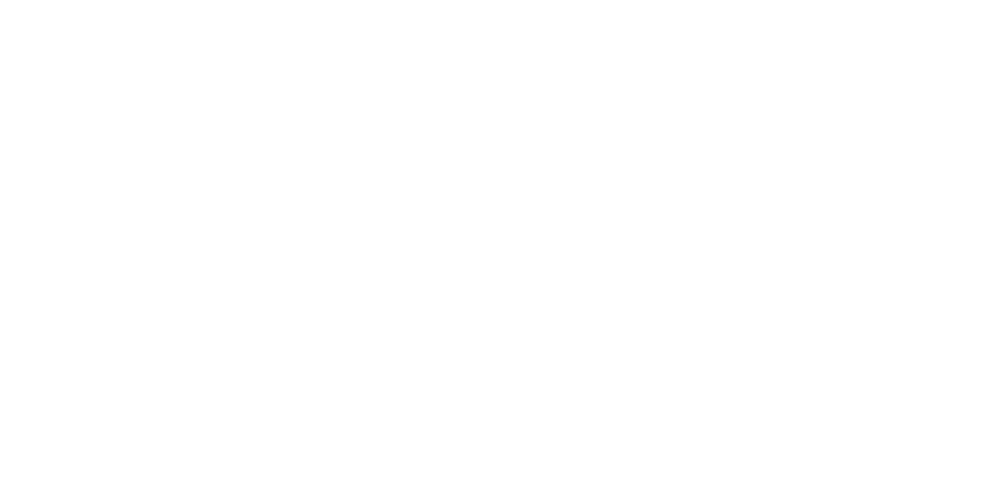

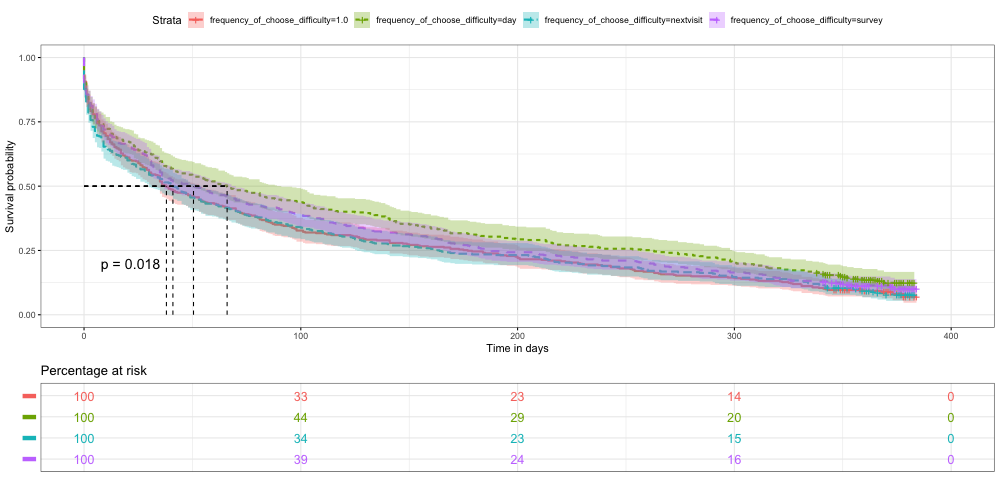

In [117]:
# noexport

condition_to_installs = get_conditions_to_install_list_in_abtest('frequency_of_choose_difficulty', ['1.0', 'nextvisit', 'day', 'survey'])
retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, 'frequency_of_choose_difficulty')
plot_attrition(retention_info, 'frequency_of_choose_difficulty')
#plot_attrition_for_abtest_groups_by_install('frequency_of_choose_difficulty', ['1.0', 'nextvisit', 'day', 'survey'])

In [118]:
# noexport

condition_to_installs['1.0'].remove('ab3965ad71bf9b625e270489')
condition_to_installs['survey'].remove('7d2d5aedfa833074112ded04')

In [77]:
#del condition_to_installs['survey']

In [78]:
#print(condition_to_installs)

In [79]:
#set(list(retention_info['Experience_Sampling_Frequency'])) #= map(lambda x: {'survey': 'Survey', }[x])

In [126]:
# noexport

retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, 'frequency_of_choose_difficulty')
retention_info = retention_info.rename(columns={"frequency_of_choose_difficulty": "Frequency"})

In [127]:
# noexport

retention_info['Frequency'] = retention_info['Frequency'].replace(
  '1.0', 'Every Visit, Optional Choice' # if don't answer then random 
).replace(
  'day', 'Once Per Day, Forced Choice'
).replace(
  'nextvisit', 'Every Visit, Forced Choice'
).replace(
  'survey', 'Choose Frequency'
)


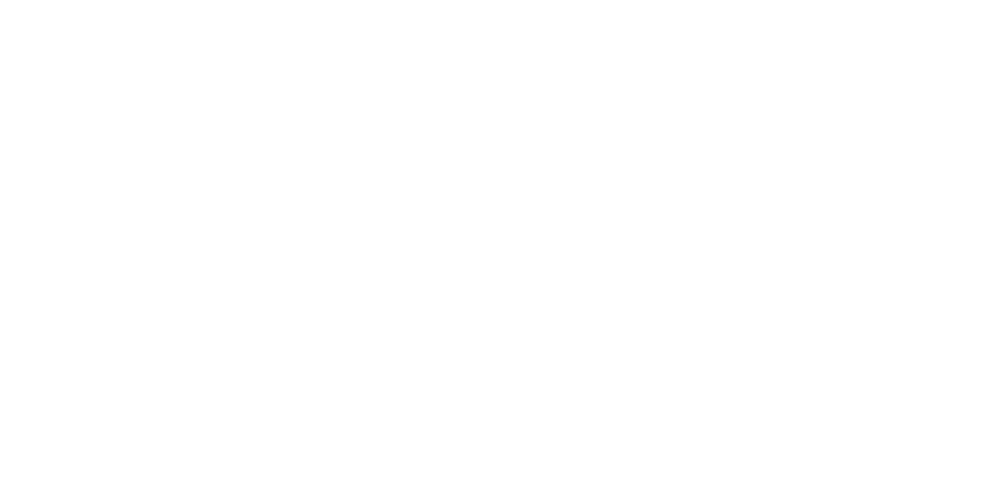

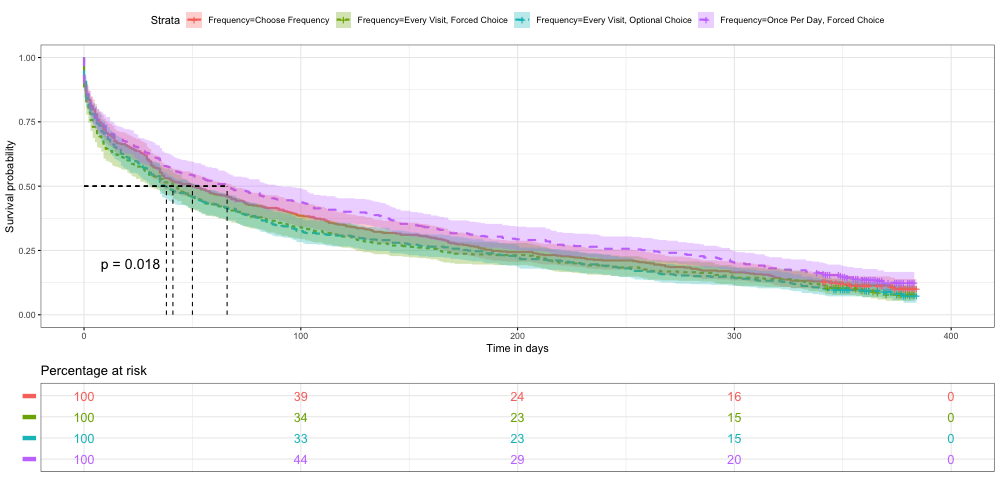

R[write to console]: Saving 13.9 x 6.67 in image



NULL


In [128]:
# noexport

# ADD TO SUPPLEMENT

plot_attrition(retention_info, 'Frequency')
plot_attrition_save(retention_info, 'Frequency', 'experience_sampling_frequency')

In [129]:
# noexport

r_assign('plot_attrition_df', retention_info)


In [134]:
%%R -w 1000
plot_attrition_df$lifetime <- as.numeric(plot_attrition_df$lifetime)
plot_attrition_df$attritioned <- as.logical(plot_attrition_df$attritioned)
plot_attrition_df$Frequency <- as.factor(plot_attrition_df$Frequency)
plot_attrition_df$Frequency <- factor(plot_attrition_df$Frequency, levels = c('Once Per Day, Forced Choice', 'Every Visit, Forced Choice', 'Every Visit, Optional Choice', 'Choose Frequency'))
library("survival")
library("survminer")
#fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
#fit <- survfit(res.cox, data=plot_attrition_df)
fit <- survfit(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
#fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
summary(fit)
ggsurv <- ggsurvplot(fit,
  pval = TRUE,
  pval.method = TRUE,
  conf.int = TRUE,
  censor = FALSE,
  risk.table = "percentage", # Add risk table
  xlab = "Time in days",
  #risk.table = TRUE, # Add risk table
  risk.table.col = "strata", # Change risk table color by groups
  risk.table.y.text = FALSE,
  linetype = "strata", # Change line type by groups
  surv.median.line = "hv", # Specify median survival
  ggtheme = theme_bw(), # Change ggplot2 theme
  tables.theme = clean_theme(),
  #font.x = 40, #c(80, "bold"),
  #font.y = 40, #c(80, "bold"),
  #risk.table.fontsize = 40,
  #pval.size = 60,
)
#ggsurv$plot <- ggsurv$plot + theme(legend.text = element_text(size = 60, color = "black"))
#ggsurv$plot <- ggsurv$plot + theme(legend.text = element_text(size = 80, color = "black", face = "bold"))
#ggsurv
ggsave("experience_sampling_frequency.png", plot=print(ggsurv), dpi = 300)


R[write to console]: Saving 13.9 x 6.67 in image



In [138]:
%%R -w 1000

fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
summary(fit)

Call:
coxph(formula = Surv(lifetime, attritioned) ~ Frequency, data = plot_attrition_df)

  n= 1581, number of events= 1414 

                                         coef exp(coef) se(coef)     z Pr(>|z|)
FrequencyEvery Visit, Forced Choice   0.21276   1.23709  0.07722 2.755  0.00586
FrequencyEvery Visit, Optional Choice 0.20347   1.22565  0.07634 2.665  0.00769
FrequencyChoose Frequency             0.10535   1.11110  0.07514 1.402  0.16091
                                        
FrequencyEvery Visit, Forced Choice   **
FrequencyEvery Visit, Optional Choice **
FrequencyChoose Frequency               
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                                      exp(coef) exp(-coef) lower .95 upper .95
FrequencyEvery Visit, Forced Choice       1.237     0.8084    1.0633     1.439
FrequencyEvery Visit, Optional Choice     1.226     0.8159    1.0553     1.423
FrequencyChoose Frequency                 1.111     0.9000    0.9589     1.287

Conco

In [137]:
%%R -w 1000

fit <- coxph(Surv(lifetime, attritioned) ~ Frequency, data=plot_attrition_df)
#summary(fit)
library('tab')
library('knitr')
show(kable(tabcoxph(fit), format='latex'))


\begin{tabular}{l|l|l|l}
\hline
Variable & Beta (SE) & HR (95\% CI) & P\\
\hline
Frequency &  &  & \\
\hline
\textbackslash{} \textbackslash{} \textbackslash{} Once Per Day, Forced Choice (ref) & - & - & -\\
\hline
\textbackslash{} \textbackslash{} \textbackslash{} Every Visit, Forced Choice & 0.21 (0.08) & 1.24 (1.06, 1.44) & 0.006\\
\hline
\textbackslash{} \textbackslash{} \textbackslash{} Every Visit, Optional Choice & 0.20 (0.08) & 1.23 (1.06, 1.42) & 0.008\\
\hline
\textbackslash{} \textbackslash{} \textbackslash{} Choose\textbackslash{} \textbackslash{} \textbackslash{} & 0.11 (0.08) & 1.11 (0.96, 1.29) & 0.16\\
\hline
\end{tabular}


In [122]:
# noexport

len(set(list(retention_info['install'])))

1581

In [123]:
# noexport

max(list(retention_info['lifetime']))

384

In [85]:
#plot_attrition_for_abtest_groups_by_install('frequency_of_choose_difficulty', ['0.0', 'survey'])
#condition_to_installs = get_conditions_to_install_list_in_abtest('frequency_of_choose_difficulty', ['0.0', 'survey'])
#print(condition_to_installs)

In [86]:
# noexport

print(retention_info[retention_info['lifetime'] > 120])


      lifetime  attritioned                   install  \
0          352        False  001330739e12b23362489fab   
1          361        False  00b89cab2eee3a04c3c5141f   
2          378        False  0264eebc66623e11b032dd57   
5          344        False  03e0e25dbeb94b3be746aaf2   
6          196         True  040a863c99828c2e9b1ca302   
...        ...          ...                       ...   
1561       356        False  f3f77b5258d939c096dd23bf   
1562       352        False  f460bcc512b7c01ab50bf6d1   
1563       166         True  f4694a5f5ac3833620626b3b   
1569       205         True  f8673cf9ba34f62cdb686ddc   
1575       160         True  fa1827da276f9b521f0c59c5   

                 Choice_Frequency  
0     Once Per Day, Forced Choice  
1     Once Per Day, Forced Choice  
2     Once Per Day, Forced Choice  
5     Once Per Day, Forced Choice  
6     Once Per Day, Forced Choice  
...                           ...  
1561   Every Visit, Forced Choice  
1562   Every Visit, Forced 

In [87]:
# noexport

#plot_attrition_for_abtest_groups_by_install('frequency_of_choose_difficulty', ['1.0', 'nextvisit', 'day', 'survey'])
#def plot_attrition_for_abtest_groups_by_install(abtest_name, groups):
#condition_to_installs = get_conditions_to_install_list_in_abtest('frequency_of_choose_difficulty', ['1.0', 'nextvisit', 'day', 'survey'])
#retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, 'frequency_of_choose_difficulty')
plot_attrition(retention_info, 'Experience_Sampling_Frequency')

R[write to console]: Error in `$<-.data.frame`(`*tmp*`, "Experience_Sampling_Frequency", value = integer(0)) : 
  替换数据里有0行，但数据有1581




Error in `$<-.data.frame`(`*tmp*`, "Experience_Sampling_Frequency", value = integer(0)) : 
  替换数据里有0行，但数据有1581


In [88]:
# def get_users_with_experiment_vars():
#   collection_names = get_collection_names()
#   output = []
#   for x in collection_names:
#     if x.endswith('_synced:experiment_vars'):
#       user = x.replace('_synced:experiment_vars', '')
#       output.append(user)
#   return output

# def get_installs_with_experiment_vars():
#   output = set()
#   user_list = get_users_with_choose_difficulty()
#   for user in user_list:
#     for item in get_collection_items(user + '_synced:experiment_vars'):
#       install_id = item.get('install_id')
#       if install_id == None:
#         continue
#       output.add(install_id)
#   return sorted(list(output))

In [89]:
#print(len(get_installs_with_experiment_vars()))

In [90]:


# def get_abtest_settings_for_install_uncached(install_id):
#   output = {}
#   collection_items = get_collection_for_install(install_id, 'synced:experiment_vars')
#   for item in collection_items:
#     if 'key' not in item:
#       continue
#     if 'val' not in item:
#       continue
#     key = item['key']
#     val = item['val']
#     output[key] = val
#     #if key == 'difficulty_selection_screen' and val != 'nodefault_forcedchoice':
#     #  print(val)
#   return output



In [91]:
#condition_to_installs = get_conditions_to_install_list_in_abtest('difficulty_selection_screen', ['nodefault_optional', 'survey_nochoice_nothing', 'survey_nochoice_easy', 'survey_nochoice_medium', 'survey_nochoice_hard'])
#condition_to_installs = get_conditions_to_install_list_in_abtest_nocheck('difficulty_selection_screen')

#print(condition_to_installs)
#plot_attrition_for_abtest_groups_by_install('difficulty_selection_screen', ['nodefault_optional', 'survey_nochoice_nothing', 'survey_nochoice_easy', 'survey_nochoice_medium', 'survey_nochoice_hard'])

In [92]:
#for k,v in condition_to_installs.items():
#  print(k, len(v))

In [93]:
# noexport

def main():
  conditions_set = set()
  for install in get_installs_with_choose_difficulty():
    all_conditions = get_abtest_experiment_conditions_for_install(install)
    #options_tested = all_conditions.get('difficulty_selection_screen')
    options_tested = all_conditions.get('frequency_of_choose_difficulty')
    if type(options_tested) == list:
      options_tested = tuple(options_tested)
    conditions_set.add(options_tested)
  return conditions_set

print(main())

{('1.0',), ('1.0', 'nextvisit', 'day', 'survey'), ('0.5',), ('0.0', '0.25', '0.5', '1.0'), ('survey',), None, ('0.0', 'survey')}
